# Package

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Importation

In [1]:
# Lire le fichier brut
with open("lbl-tcp-3.tcp", "r", encoding="latin-1") as f:
    lignes = f.readlines()

# Afficher quelques lignes pour voir la structure
for i, ligne in enumerate(lignes[:20]):  # juste les 20 premières
    print(i, ligne.strip())

0 759103800.008185 1 2 23 2436 1
1 0.010445 2 1 2436 23 2
2 0.023775 1 2 23 2436 2
3 0.026558 2 1 2436 23 1
4 0.029002 3 4 3930 119 42
5 0.032439 4 3 119 3930 15
6 0.049618 1 2 23 2436 1
7 0.052431 5 2 14037 23 2
8 0.056457 2 5 23 14037 2
9 0.057815 6 7 23 1502 414
10 0.072126 8 9 1023 513 0
11 0.098415 3 4 3930 119 55
12 0.104465 4 3 119 3930 15
13 0.122345 10 11 6000 2290 0
14 0.124490 7 6 1502 23 0
15 0.125228 2 1 2436 23 1
16 0.138935 1 2 23 2436 1
17 0.139950 12 13 1208 6000 64
18 0.140930 2 1 2436 23 1
19 0.146912 13 12 6000 1208 32


In [42]:
path = "lbl-tcp-3.tcp"
colnames = ["ts", "src_id", "dst_id", "src_port", "dst_port", "val"]
df = pd.read_csv(
    path, sep=r"\s+", header=None, names=colnames, engine="python",
    dtype={"ts": float, "src_id": np.int64, "dst_id": np.int64,
           "src_port": np.int64, "dst_port": np.int64, "val": np.int64}
)

In [48]:
# ---------- Fenêtrage 10 s ----------
t0 = df['ts'].min()
# fenêtres [0,10), [10,20), ...
df['Interval'] = np.floor((df['ts'] - t0 - 1e-9) / 10).astype(int)
df = df[df['Interval'].between(0, 719)]

# Nombre d'événements par fenêtre (720 pas)
ts_series = (
    df.groupby('Interval').size()
      .reindex(range(720), fill_value=0)
)

In [45]:
# ---------- Index temporel (DatetimeIndex régulier 10 s) ----------
# On ancre les deltas sur la vraie horloge:
origin = pd.to_datetime(t0, unit='s').floor('10S')  # ancre alignée sur 10 s
dt_index = pd.date_range(start=origin, periods=len(ts_series), freq='10S')
y = pd.Series(ts_series.values, index=dt_index, name='count')  # DatetimeIndex + freq=10S

C:\Users\Mita\AppData\Local\Temp\ipykernel_8952\1349177612.py:3: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  origin = pd.to_datetime(t0, unit='s').floor('10S')  # ancre alignée sur 10 s
C:\Users\Mita\AppData\Local\Temp\ipykernel_8952\1349177612.py:4: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  dt_index = pd.date_range(start=origin, periods=len(ts_series), freq='10S')


# Graphique du Time Series

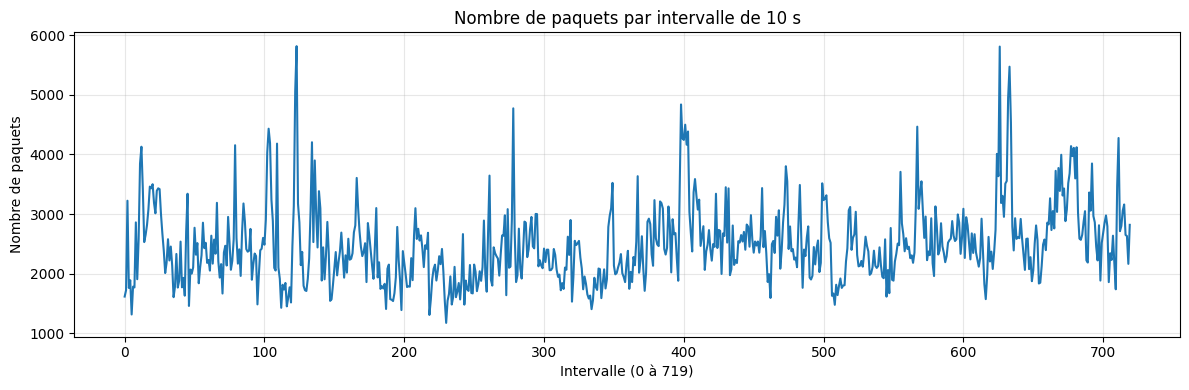

In [46]:
plt.figure(figsize=(12,4))
ts_series.plot()
plt.title("Nombre de paquets par intervalle de 10 s")
plt.xlabel("Intervalle (0 à 719)")
plt.ylabel("Nombre de paquets")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Le traffic n'augmente pas dans le temps et on observe pas une certaine saisonnalité. Intuitivement, il est stationnaire. Par contre, on s'apercôit une grande volatilité.

# Stationnarité

In [47]:
result = adfuller(ts_series)

print("Statistique ADF:", result[0])
print("p-value:", result[1])
print("Valeurs critiques:", result[4])
if result[1] < 0.05:
    print("✅ On rejette H0 : la série est stationnaire.")
else:
    print("❌ On ne rejette pas H0 : la série est non-stationnaire.")

Statistique ADF: -8.273264859803446
p-value: 4.730303272479693e-13
Valeurs critiques: {'1%': np.float64(-3.439516060164992), '5%': np.float64(-2.8655850998755263), '10%': np.float64(-2.5689240826597173)}
✅ On rejette H0 : la série est stationnaire.


# Analyse de l'autocorrélation

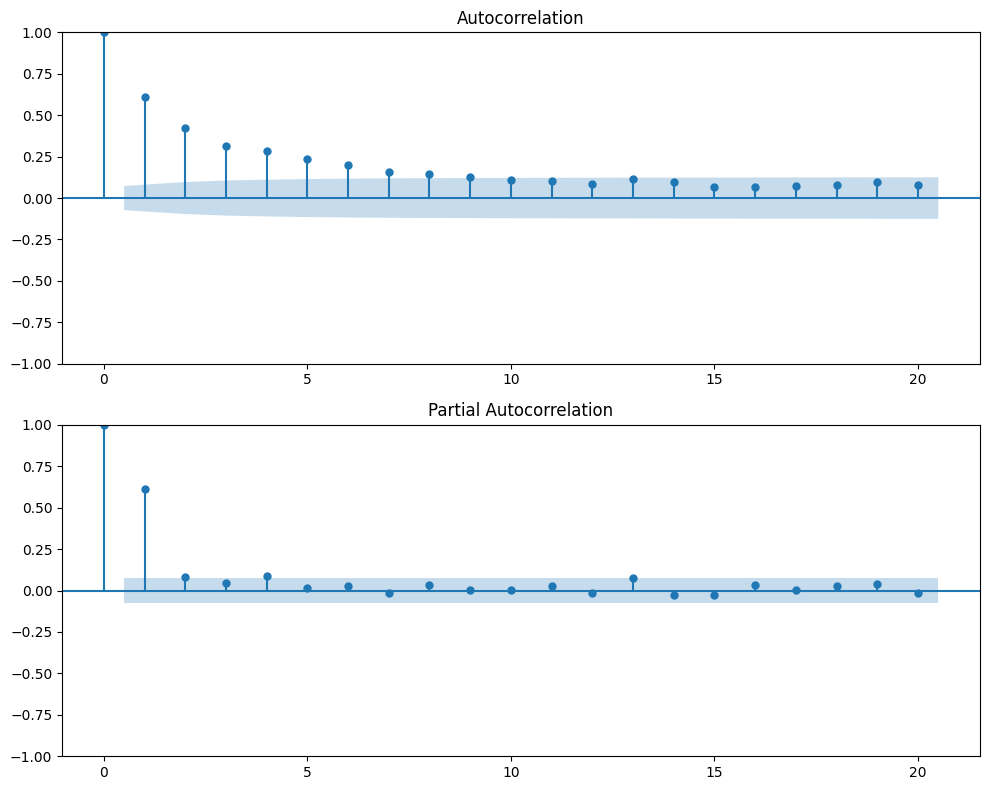

In [49]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 8))
plot_acf(ts_series, ax=ax[0], lags=20, alpha=0.05)
plot_pacf(ts_series, ax=ax[1], lags=20, alpha=0.05)

plt.tight_layout()
plt.show()

Ces graphiques montrent la corrélation de la série temporelle avec elle-même avec un retards maximal de 20. Lorsque les valeurs sont proches de 0, celà veut dire que les observations consécutives sont non corrélées. Par contre, lorsqu'elles sont proches de 1 ou -1, l'autocorrélation est présente.  

L'ACF et le PACF retournent à chacun des intervalles de confiance. La corrélation est significative lorsqu'elle déborde de cette intervalle. 

Pour le PACF, le retards égal à 1 est très significatifs et le reste est relativement faible. Une petite élevation se situe au 13è lags. L'autocorrélation s'accumule jusqu'à la 7è lags comme le montre le graphique de l'autocorrélation. 

Ces résultats justifient l'utilisation des modèles auto-régressifs. Pour AR(p), p devrait être au plus égal à 7. Nous allons donc chercher maintenant la valeur optimale de p.  

# Choix de paramètre du modèle AR(p)

## Critère AIC

In [102]:
# ============================================
# Étape 1 — Préparation des données et des paramètres
# ============================================
y = pd.Series(ts_series, dtype = float).dropna()
n = len(y)
h = int(0.7 * n)
y_train, y_test = y[:h], y[h:]
idx_train, idx_test = y_train.index, y_test.index
pmax = 7
len(y_train) , len(y_test)

(503, 217)

In [103]:
# Etape 2 : AIC
for p in range (1, pmax + 1):
    mod = ARIMA (endog = y_train, order = (p, 0, 0))
    res = mod.fit()
    print(f"aic ({p}) : {res.aic}")

aic (1) : 7718.941074528273
aic (2) : 7719.859926703922
aic (3) : 7719.784809197334
aic (4) : 7720.5232550447745
aic (5) : 7721.528798554384
aic (6) : 7723.507041758614
aic (7) : 7724.947712775847


Plus la valeur de p augmente, plus AIC augmente en principe. Mais de p = 6 à 7, il commence à diminuer. Ce qui laisse présager que l'on peut trouver un meilleur p à 13? Essayons

In [104]:
# Etape 2 : AIC
pmax = 13
for p in range (1, pmax + 1):
    mod = ARIMA (endog = y_train, order = (p, 0, 0))
    res = mod.fit()
    print(f"aic ({p}) : {res.aic}")

aic (1) : 7718.941074528273
aic (2) : 7719.859926703922
aic (3) : 7719.784809197334
aic (4) : 7720.5232550447745
aic (5) : 7721.528798554384
aic (6) : 7723.507041758614
aic (7) : 7724.947712775847
aic (8) : 7726.396314268929
aic (9) : 7728.102913392862
aic (10) : 7729.882886247224
aic (11) : 7731.804977270207
aic (12) : 7733.956739687868
aic (13) : 7732.88821482051


Pour AIC, AR(p) = AR(1). Essayons avec BIC.

In [105]:
# BIC
for p in range (1, pmax + 1):
    mod = ARIMA (endog = y_train, order = (p, 0, 0))
    res = mod.fit()
    print(f"aic ({p}) : {res.bic}")

aic (1) : 7731.602845038572
aic (2) : 7736.742287384321
aic (3) : 7740.887760047833
aic (4) : 7745.8467960653725
aic (5) : 7751.072929745082
aic (6) : 7757.271763119412
aic (7) : 7762.933024306745
aic (8) : 7768.602215969926
aic (9) : 7774.529405263959
aic (10) : 7780.529968288421
aic (11) : 7786.672649481504
aic (12) : 7793.045002069264
aic (13) : 7796.197067372006


Pareil, BIC confirme qu'il faut avoir AR(1). Voyons voir maintenant le cas de Backtesting

In [106]:
# Etablir une fonction de Backtesting pour le choix de p dans AR(p)
def ts_backtesting (s, pmax, nchunks) :
    s = pd.Series(s).dropna()
    n = len(s)
    cuts = np.linspace(0, n , nchunks + 1, dtype = int) # Puisque iloc en bas exige un float
    results = []

    for k in range ( nchunks - 1 ) : 
        for p in range (1 , pmax + 1) : 
            train = s.iloc[:cuts[k+1]]
            validation = s.iloc[cuts[k+1]:cuts[k+2]]

            try : 
                mod = ARIMA(train, order = (p,0,0))
                res = mod.fit()

                forecast = pd.Series(res.forecast(steps = len(validation)), index=validation.index)
                rmse_fold = np.sqrt(((validation - forecast) ** 2).mean())
                
                results.append((p, rmse_fold))
        
            except Exception : 
                rmse.append(np.nan)

    df_results = pd.DataFrame(results, columns=["p", "rmse"])
    return df_results.groupby("p")["rmse"].mean()

In [107]:
# Appeler la fonction de Backtesting
ts_backtesting(ts_series, pmax=pmax, nchunks = 5)

p
1     634.227435
2     634.126009
3     634.438345
4     634.465963
5     634.295649
6     634.411143
7     634.235775
8     634.281440
9     634.170347
10    634.287050
11    634.189823
12    634.098379
13    634.007343
Name: rmse, dtype: float64

Ici, c'est p = 13 qui donne le RMSE le plus bas. 

# Tester les modèles et choisir

## Réentrainement des modèles

In [ ]:
# AIC et BIC
mod_ar_aic_bic = ARIMA(endog = y_train, order = (1,0,0))
res_ar_aic_bic = mod_ar_aic_bic.fit()

In [109]:
# backtesting
mod_ar_rmse = ARIMA(endog=y_train, order = (13,0,0))
res_ar_rmse = mod_ar_rmse.fit()

# Validation modèle

In [139]:
# Analyse de residu
ar_resid_aic = res_ar_aic_bic.resid
ar_resid_rmse = res_ar_rmse.resid

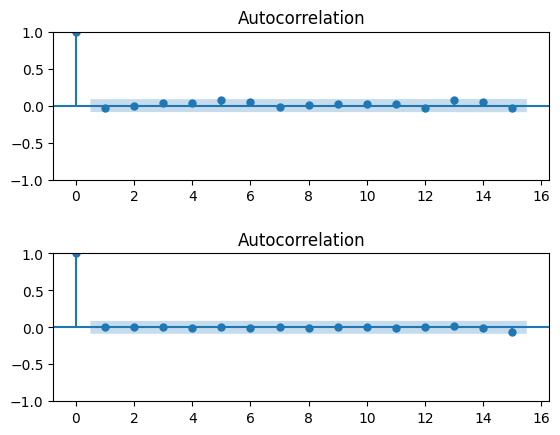

In [140]:
fig = plt.figure()

ax1 = fig.add_subplot(2,1,1)
plot_acf(ar_resid_aic, lags = 15 , ax=ax1)

ax2 = fig.add_subplot(2,1,2)
plot_acf(ar_resid_rmse, lags = 15, ax=ax2)

plt.subplots_adjust(hspace=0.5)

plt.show()

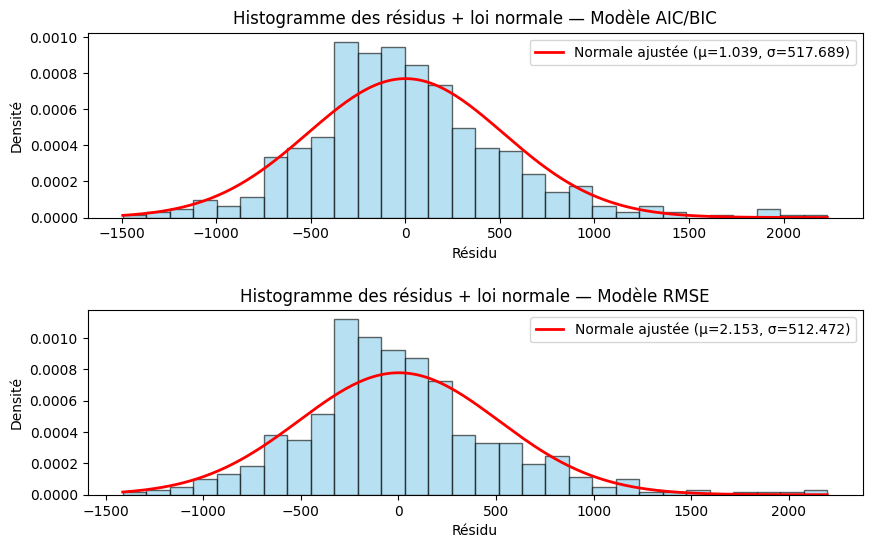

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Résidus (on sécurise en retirant d'éventuels NaN)
ar_resid_aic  = res_ar_aic_bic.resid.dropna()
ar_resid_rmse = res_ar_rmse.resid.dropna()

# Paramètres d'affichage
bins = 30

fig = plt.figure(figsize=(10, 6))

# --- 1) Histogramme + normale ajustée : modèle "AIC/BIC" ---
ax1 = fig.add_subplot(2, 1, 1)
mu1, sigma1 = ar_resid_aic.mean(), ar_resid_aic.std()
ax1.hist(ar_resid_aic, bins=bins, density=True, alpha=0.6, color="skyblue", edgecolor="black")
x1 = np.linspace(ar_resid_aic.min(), ar_resid_aic.max(), 200)
ax1.plot(x1, norm.pdf(x1, mu1, sigma1), "r-", lw=2,
         label=f"Normale ajustée (μ={mu1:.3f}, σ={sigma1:.3f})")
ax1.set_title("Histogramme des résidus + loi normale — Modèle AIC/BIC")
ax1.set_xlabel("Résidu")
ax1.set_ylabel("Densité")
ax1.legend()

# --- 2) Histogramme + normale ajustée : modèle "RMSE" ---
ax2 = fig.add_subplot(2, 1, 2)
mu2, sigma2 = ar_resid_rmse.mean(), ar_resid_rmse.std()
ax2.hist(ar_resid_rmse, bins=bins, density=True, alpha=0.6, color="skyblue", edgecolor="black")
x2 = np.linspace(ar_resid_rmse.min(), ar_resid_rmse.max(), 200)
ax2.plot(x2, norm.pdf(x2, mu2, sigma2), "r-", lw=2,
         label=f"Normale ajustée (μ={mu2:.3f}, σ={sigma2:.3f})")
ax2.set_title("Histogramme des résidus + loi normale — Modèle RMSE")
ax2.set_xlabel("Résidu")
ax2.set_ylabel("Densité")
ax2.legend()

plt.subplots_adjust(hspace=0.5)
plt.show()

In [144]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera


# Assure-toi d'avoir défini :
# ar_resid_aic  = res_ar_aic_bic.resid
# ar_resid_rmse = res_ar_rmse.resid

def test_residus(name, resid, lags=[3], alpha=0.05):
    r = resid.dropna()

    print(f"\n===== Tests résidus — {name} =====")
    # Ljung-Box
    lb = acorr_ljungbox(r, lags=lags, return_df=True)
    print("Ljung-Box:")
    print(lb)

    # Jarque-Bera
    jb_stat, jb_pvalue, skew, kurtosis = jarque_bera(r)
    print(f"\nJarque-Bera statistic : {jb_stat:.3f}")
    print(f"p-value               : {jb_pvalue:.3f}")
    print(f"Asymétrie (skewness)  : {skew:.3f}")
    print(f"Kurtosis              : {kurtosis:.3f}")

    # Commentaires automatiques (sur le dernier lag testé)
    if lb['lb_pvalue'].iloc[-1] > alpha:
        print("→ Résidus ~ bruit blanc (pas d'autocorrélation détectée).")
    else:
        print("→ Résidus autocorrélés (modèle à améliorer).")

    if jb_pvalue > alpha:
        print("→ Résidus ~ distribution normale.")
    else:
        print("→ Résidus non normaux (asymétrie/kurtosis anormale).")

# Lancer pour les deux séries
test_residus("Modèle AIC/BIC", ar_resid_aic,  lags=[3])
test_residus("Modèle RMSE",    ar_resid_rmse, lags=[3])


===== Tests résidus — Modèle AIC/BIC =====
Ljung-Box:
    lb_stat  lb_pvalue
3  1.064248   0.785711

Jarque-Bera statistic : 119.275
p-value               : 0.000
Asymétrie (skewness)  : 0.713
Kurtosis              : 4.912
→ Résidus ~ bruit blanc (pas d'autocorrélation détectée).
→ Résidus non normaux (asymétrie/kurtosis anormale).

===== Tests résidus — Modèle RMSE =====
Ljung-Box:
    lb_stat  lb_pvalue
3  0.000889   0.999993

Jarque-Bera statistic : 131.609
p-value               : 0.000
Asymétrie (skewness)  : 0.778
Kurtosis              : 4.964
→ Résidus ~ bruit blanc (pas d'autocorrélation détectée).
→ Résidus non normaux (asymétrie/kurtosis anormale).


Les deux modèles ont été donc validé. Il est temps de passer au test et choisir le modèle final.

## Test

### Test sur AIC et BIC

In [145]:
# --- Rolling avec modèle ARIMA déjà entraîné (res_ar_aic_bic) ---
res = res_ar_aic_bic  # modèle pré-entraîné sur y_train

rolling_preds = []
conf_low = []
conf_high = []

for ts, y_true in y_test.items():  # ts = timestamp / index, y_true = valeur
    # 1-step-ahead forecast
    fc = res.get_forecast(steps=1)
    yhat = fc.predicted_mean.iloc[0]
    ci = fc.conf_int(alpha=0.05).iloc[0]  # [low, high]

    rolling_preds.append(yhat)
    conf_low.append(ci.iloc[0])
    conf_high.append(ci.iloc[1])

    # IMPORTANT : passer un array-like (longueur 1), avec le même index
    new_obs = pd.Series([y_true], index=[ts])
    res = res.append(new_obs, refit=False)

# Séries alignées sur l'index de test
rolling_preds = pd.Series(rolling_preds, index=y_test.index)
conf_low = pd.Series(conf_low, index=y_test.index)
conf_high = pd.Series(conf_high, index=y_test.index)

# RMSE
rmse_rolling = np.sqrt(mean_squared_error(y_test, rolling_preds))
print(f"RMSE ARIMA rolling = {rmse_rolling:.4f}")

RMSE ARIMA rolling = 518.4097


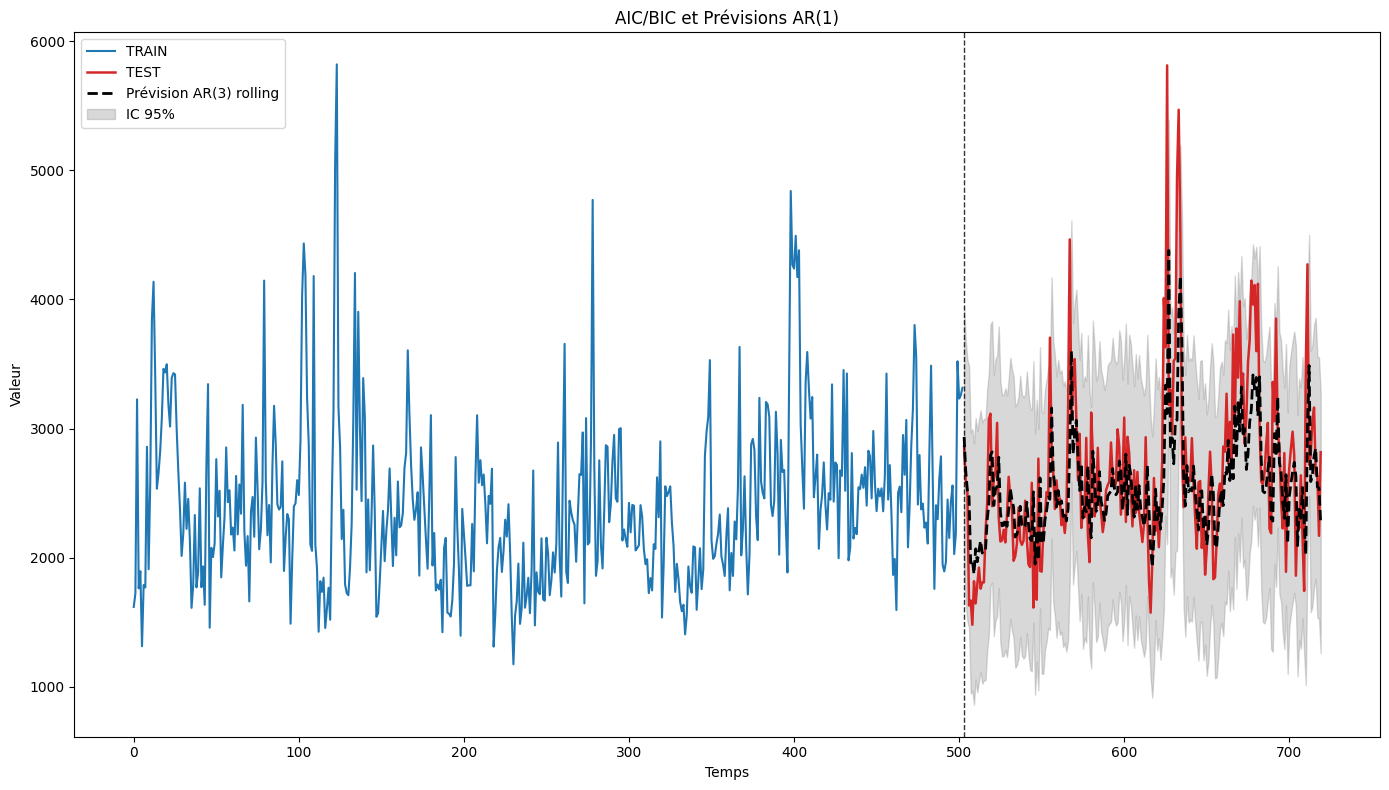

In [146]:
# --- Graphique ---
plt.figure(figsize=(14,8))
plt.plot(y_train.index, y_train.values, color="tab:blue", linewidth=1.5, label="TRAIN")
plt.plot(y_test.index, y_test.values, color="tab:red", linewidth=1.8, label="TEST")
plt.plot(y_test.index, rolling_preds.values, color="black", linewidth=2, linestyle="--", label="Prévision AR(3) rolling")
plt.fill_between(y_test.index, conf_low.values, conf_high.values, color="gray", alpha=0.3, label="IC 95%")
plt.axvline(y_test.index[0], linestyle="--", linewidth=1, color="black", alpha=0.8)
plt.title("AIC/BIC et Prévisions AR(1)")
plt.xlabel("Temps")
plt.ylabel("Valeur")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

### Test en RMSE

In [147]:
# --- Rolling avec modèle ARIMA déjà entraîné (res_ar_aic_bic) ---
res = res_ar_rmse  # modèle pré-entraîné sur y_train

rolling_preds = []
conf_low = []
conf_high = []

for ts, y_true in y_test.items():  # ts = timestamp / index, y_true = valeur
    # 1-step-ahead forecast
    fc = res.get_forecast(steps=1)
    yhat = fc.predicted_mean.iloc[0]
    ci = fc.conf_int(alpha=0.05).iloc[0]  # [low, high]

    rolling_preds.append(yhat)
    conf_low.append(ci.iloc[0])
    conf_high.append(ci.iloc[1])

    # IMPORTANT : passer un array-like (longueur 1), avec le même index
    new_obs = pd.Series([y_true], index=[ts])
    res = res.append(new_obs, refit=False)

# Séries alignées sur l'index de test
rolling_preds = pd.Series(rolling_preds, index=y_test.index)
conf_low = pd.Series(conf_low, index=y_test.index)
conf_high = pd.Series(conf_high, index=y_test.index)

# RMSE
rmse_rolling = np.sqrt(mean_squared_error(y_test, rolling_preds))
print(f"RMSE ARIMA rolling = {rmse_rolling:.4f}")

RMSE ARIMA rolling = 512.4392


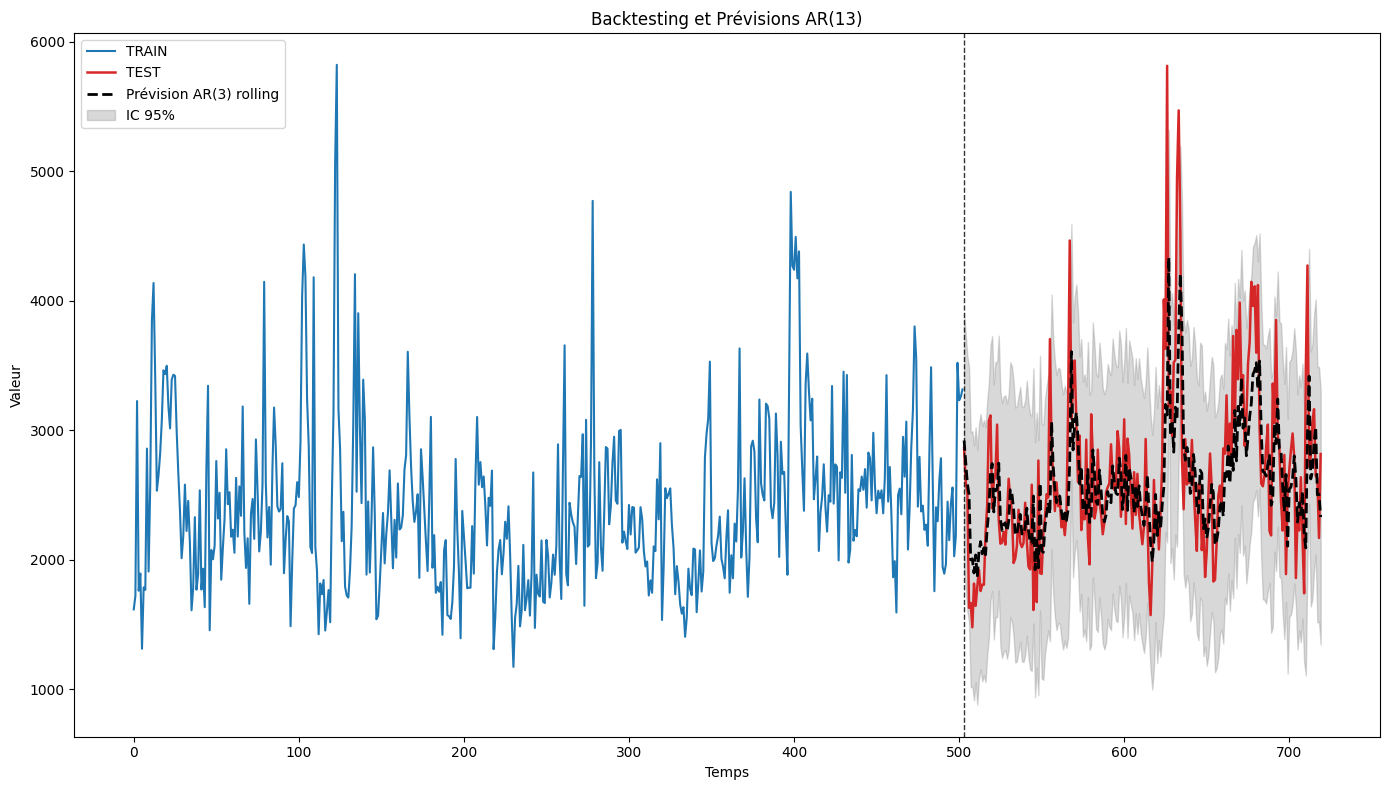

In [148]:
# --- Graphique ---
plt.figure(figsize=(14,8))
plt.plot(y_train.index, y_train.values, color="tab:blue", linewidth=1.5, label="TRAIN")
plt.plot(y_test.index, y_test.values, color="tab:red", linewidth=1.8, label="TEST")
plt.plot(y_test.index, rolling_preds.values, color="black", linewidth=2, linestyle="--", label="Prévision AR(3) rolling")
plt.fill_between(y_test.index, conf_low.values, conf_high.values, color="gray", alpha=0.3, label="IC 95%")
plt.axvline(y_test.index[0], linestyle="--", linewidth=1, color="black", alpha=0.8)
plt.title("Backtesting et Prévisions AR(13)")
plt.xlabel("Temps")
plt.ylabel("Valeur")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

Le RMSE obtenu à partir de AIC/BIC est de 518 avec le modèle AR(1) contre 512 pour le RMSE avec le modèle AR(13). Le Backtesting maximise alors la prévision maix au prix d'un modèle compliqué. 

Vu que la différence de performance n'est pas si éloignée, nous préférons AR(1), un modèle parcimonieux mais efficace.  